# Removal of cell-cycle and sex covariates (robustness to hyper-parameters)


Given the dataset of Drosophila myoblasts [[1]](https://doi.org/10.7554/eLife.61276) we showcase robustness of `SiFT` to kernel hyper-parameters.

[[1] Everetts, N. J., Worley, M. I., Yasutomi, R., Yosef, N., & Hariharan, I. K. (2021). Single-cell transcriptomics of the Drosophila wing disc reveals instructive epithelium-to-myoblast interactions. Elife, 10, e61276.](https://doi.org/10.7554/eLife.61276)

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata
import pandas as pd
import scanpy as sc
import numpy as np

import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import time
from scipy.sparse import issparse

# import sift

In [3]:
module_path = os.path.dirname(os.path.dirname(os.path.abspath(os.path.join(".."))))

sys.path.append(module_path)
sys.path.append(os.path.join(module_path, "sift-sc"))

import sift

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR

## Set Parameteres

In [6]:
DATA_DIR = DATA_DIR / "nuisance_drosophila"
FIG_DIR = FIG_DIR / "nuisance_drosophila"


In [7]:
fontsize = 25
size = 4
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (size, size)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = fontsize
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = fontsize-4
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = fontsize-4
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = fontsize+4
plt.rcParams['legend.handlelength'] = 1.4 
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

sns.set(rc={"figure.dpi":300, "savefig.dpi":300})
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid", {"xtick.direction": "out", "xtick.major.size": 3.0, "xtick.minor.size": 3.0,
                            "ytick.color": ".15", "ytick.direction": "out", "ytick.major.size": 3.0, 
                            "ytick.minor.size": 3.0, "font": ["DejaVu Sans"], "font.scale": 1, 
                            "legend.frameon":"True"})

In [8]:
method_colors = ["#5C88DAFF", "#84BD00FF", "#FFCD00FF", "#7C878EFF"] 
coupled_method_colors = ["#5C88DAFF", "#5C88DA99", "#84BD00FF",  "#84BD0099", "#FFCD00FF", "#7C878EFF"]

## Helper functions

### Set adata colors

In [9]:
def set_adata_colors(adata):
    # set sex
    adata.uns["sex_colors"] = list(sns.color_palette("colorblind", 2).as_hex()[::-1])
    
    # set phase
    adata.obs["phase"] = adata.obs["phase"].astype("category")
    adata.obs["phase"] = adata.obs["phase"].cat.reorder_categories(['G1',  'S', 'G2M'])
    
    colors_ = list(sns.color_palette("Paired", 6).as_hex())
    adata.uns["phase_colors"] = [colors_[1], colors_[3], colors_[5]]
    
    # set batch
    adata.obs["batch_str"] = adata.obs["batch"].copy()
    adata.obs["batch_str"] = adata.obs["batch_str"].cat.rename_categories({
        '96hr_1': "96hr (1)", 
        '96hr_2': "96hr (2)", 
        '120hr_1': "120hr (1)", 
        '120hr_2': "120hr (2)", 
    })
    adata.uns["batch_str_colors"] = ["#92aeb3", "#c9c89d", "#999999", "#392b2b"]

    # set phase-sex
    adata.obs["phase_sex"] = adata.obs["phase"].astype(str) + "_" + adata.obs["sex"].astype(str)
    adata.obs["phase_sex"] = adata.obs["phase_sex"].astype("category")
    adata.obs["phase_sex"] = adata.obs["phase_sex"].cat.reorder_categories([
        'G1_female',  'G1_male', 
        'S_female',  'S_male', 
        'G2M_female',  'G2M_male', 
    ])
    adata.obs["phase_sex"] = adata.obs["phase_sex"].cat.rename_categories({
        'G1_female' : "G1 (f)",  
        'G1_male': "G1 (m)",
        'S_female': "S (f)",  
        'S_male': "S (m)",
        'G2M_female': "G2M (f)",
        'G2M_male': "G2M (m)", 
    })
    adata.uns["phase_sex_colors"] = list(sns.color_palette("Paired", 6).as_hex())
    

    
    return adata

## Setting parameteres

In [10]:
# list of sex genes and cell cycle genes we will be conditioning on
sex_genes = ["lncRNA:roX1", "lncRNA:roX2", "Sxl", "msl-2"]

cell_cycle_genes = ['PCNA', 'dnk', 'RnrS', 'RnrL', 'Claspin', 'Mcm5', 'Caf1-180',
       'RPA2', 'HipHop', 'stg', 'Mcm6', 'dup', 'WRNexo', 'Mcm7', 'dpa',
       'CG10336', 'Mcm3', 'Mcm2', 'RpA-70', 'Chrac-14', 'CG13690', 'RPA3',
       'asf1', 'DNApol-alpha73', 'CycE', 'DNApol-alpha50',
       'Kmn1', 'Lam', 'Nph', 'msd5', 'msd1', 'ctp', 'Set', 'scra',
       'Chrac-16', 'ncd', 'Ote', 'pzg', 'HDAC1', 'nesd', 'tum', 'CG8173',
       'aurB', 'feo', 'pav', 'CG6767', 'sip2', 'Det', 'Cks30A', 'CycB',
       'B52']

# list of genes we're interested in
genes_of_interest = [
    "Argk",
    "Nrt",
    "Ten-a",
    "Ten-m",
    "wb",
    "Act57B",
    "drl",
    "mid",
    "nemy",
    "lms",
    "CG11835",
    "Gyg",
    "ara",
    "tok",
    "kirre",
    "NK7.1",
    "fj",
    "beat-IIIc",
    "CG33993",
    "dpr16",
    "CG15529",
    "CG9593",
    "beat-IIb",
    "robo2",
    "Ama",
    "fz2",
    "elB",
    "noc",
    "nkd",
    "fng",
    "vg",
]

nuisance_genes = sex_genes + cell_cycle_genes

library_size = 5000

In [ ]:
# setting up anndata
adata = sc.read("/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/cellcycle_myoblasts/data/myoblasts.h5ad")
# adata = sc.read(DATA_DIR / 'myoblasts.h5ad')

In [ ]:
adata.layers['counts'] = adata.X.copy() # move count data into a layer
sc.pp.normalize_total(adata, target_sum = library_size)
sc.pp.log1p(adata) # log the data for better umap visualization later
adata.raw = adata

**Classify the `sex`**

based on the classification performed by Everetts et. al. [[1]]((https://doi.org/10.7554/eLife.61276)) (see [cell_sex_and_cell_cycle_correction.R](https://github.com/HariharanLab/Everetts_Worley_Yasutomi/blob/e1d1f10fefdab11688ad4ca0b8c2684ed47faa0c/scVI/cell_sex_and_cell_cycle_correction.R))

_We expect the data for sex genes to be bimodal, and use the minimum between peaks as a cutoff for determining male and female cells. This usually corresponds to the second extrema in the density (from left to right). However, noise and drop-outs in the data may make this difficult to calculate, so a manual cutoff may be needed instead._
  

In [ ]:
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import vectors

stats = importr("stats")

sex_gene_cutoff = {}
data_density = {}
sex_threshold_cells = {}
sex_genes = ["lncRNA:roX1", "lncRNA:roX2"]

# get density estimate

for i, gene in enumerate(sex_genes):
    column = vectors.FloatVector(adata[:, gene].X)
    data_density[gene]  = stats.density(column, adjust = 2)
    x = np.asarray(data_density[gene][0])
    y = np.asarray(data_density[gene][1])
    # find the second extrema in the density, and use this as a cutoff for cells
    sex_gene_cutoff[gene] = x[np.where(np.diff(np.diff(y) > 0))][1]
    adata.obs[f"{gene}_cutoff"] = adata[:, gene].X >= sex_gene_cutoff[gene]
    
    ax = sns.histplot(adata[:, gene].X, stat="density", bins=50, kde=True)
    ax.legend().remove()
    ax.set_xlabel(f"Log normalized counts\n{gene}")
    ax.set_ylabel(f"density")
    plt.axvline(x=sex_gene_cutoff[gene],color='red')
    plt.title(f"{gene}, cutoff={sex_gene_cutoff[gene]:.2f}")
    
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"sex_cutoff_{gene}.png", bbox_inches="tight", dpi=DPI)
    plt.show()
    
adata.obs["sex"] = "female"
adata.obs.loc[adata.obs["lncRNA:roX1_cutoff"] | adata.obs["lncRNA:roX2_cutoff"], "sex"]  = "male"


num_male = (adata.obs["sex"] == "male").sum()
num_female = (adata.obs["sex"] == "female").sum()
print(f"Number of predicted male cells: {num_male}, percentage from data: {num_male/(num_male+num_female):.2f}")
print(f"Number of predicted female cells: {num_female}, percentage from data: {num_female/(num_male+num_female):.2f}")

Classify cell cycle based on cell cycle genes from Kirchner [Drosophila_melanogaster.csv](https://github.com/hbc/tinyatlas/blob/master/cell_cycle/Drosophila_melanogaster.csv) as used in Zhu et al. [[2]](https://doi.org/10.1038/s41467-022-28915-3)

[[2] Kiat, Y., Vortman, Y., & Sapir, N. (2019). Feather moult and bird appearance are correlated with global warming over the last 200 years. Nature Communications, 10(1), 1-7.](https://doi.org/10.1038/s41467-022-28915-3)


In [ ]:
g2m_genes = [
    'Mps1', 'aurA', 'CycB', 'fzy', 'twe', 'pbl', 'RanGAP', 'stg',
    'sub', 'Su(var)205', 'Cdk1', 'Klp61F', 'pie', 'pav', 'glu', 'msps',
    'pigs', 'Nek2', 'HP1b', 'Phf7', 'Bub1', 'mars', 'Mapmodulin',
    'LBR', 'CTCF', 'Cks85A', 'HP1e', 'HP1c', 'Cap-D2', 'cmet', 'cana',
    'scra', 'BubR1', 'Det', 'vih', 'Dsp1', 'Top2'
]
s_genes = [
    'Blm', 'spn-A', 'PCNA', 'CycE', 'RnrS', 'DNApol-alpha50',
    'l(2)dtl', 'Mcm2', 'spel1', 'tos', 'dpa', 'Mcm5', 'Ts', 'Mcm6',
    'Fen1', 'Cdc45', 'Usp1', 'CG15141', 'CG10336', 'PCNA2', 'RPA2',
    'Caf1-105', 'CG11788', 'Cdc6', 'Slbp', 'Claspin',
    'DNApol-alpha180', 'RfC4', 'Psf2'
]

In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [ ]:
adata = set_adata_colors(adata)

In [ ]:
adata_nothing = adata.copy()

In [ ]:
sc.pp.scale(adata_nothing)
sc.tl.pca(adata_nothing)
sc.pp.neighbors(adata_nothing)
sc.tl.umap(adata_nothing)

In [ ]:
fig = sc.pl.umap(
        adata_nothing,
        color=["batch_str", "sex",  "phase", "phase_sex"],
        frameon=False,
        wspace=0,
        return_fig=True,
    )
fig.axes[2].set_title("cell cycle phase")
fig.axes[3].set_title("cc phase & sex")
plt.show()

In [ ]:
adata = adata[adata.obs["phase_sex"].argsort(), :]

In [ ]:
adata_nothing = adata_nothing[adata_nothing.obs["phase_sex"].argsort(), :]

In [ ]:
adata_nothing.write(DATA_DIR / "myoblasts_nothing.h5ad")

In [ ]:
adata.write(DATA_DIR / "myoblasts_annotated.h5ad")

## Read pre-processed `adata`

In [ ]:
methods = [
    "sift_knn_2",
    "sift_knn_3",
    "sift_knn_5",
    "sift_knn_10",
    "sift_knn_15",
    "nothing"
]
fnames = {method: f"myoblasts_{method}.h5ad" for method in methods}

In [ ]:
adata = sc.read(DATA_DIR + "myoblasts_annotated.h5ad")

In [ ]:
adata

In [ ]:
adatas_ = {}

# `SiFT` - knn

In [ ]:
metric = "knn"

for method in methods[:-1]:
    print(f"evaluating {method}")
    n_neighbors = int(method.split("_")[-1])
    # setting up anndata for knn

    adatas_[method] = adata.copy()
    
    # then copy the expression of the nuisance gene into adata.obsm
    adatas_[method].obsm["nuisance_genes"] = adatas_[method][:, nuisance_genes].X
    adatas_[method].uns["nuisance_genes"] = nuisance_genes
    
    
    # finally, remove the nuisance genes from the anndata
    gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
    adatas_[method] = adatas_[method][:, gene_subset].copy()

    start = time.perf_counter()
    
    print(f"running {method}")    
    kernel_key_ =  "nuisance_genes"     
    
    sft = sift.SiFT(
        adata=adatas_[method],
        kernel_key=kernel_key_,
        n_neighbors=n_neighbors,
        metric=metric,
        copy=False,
    )
    sft.filter(
        embedding_key="X",
        pseudocount=False
        )
    compute_time = time.perf_counter() - start
    print(f"{method} finished in {compute_time} sec")

    sc.tl.pca(adatas_[method],)
    sc.pp.neighbors(adatas_[method])
    sc.tl.umap(adatas_[method])

    sc.pl.umap(
        adatas_[method],
        color=["batch_str","phase", "sex", "Nrt"],
        frameon=False,
        wspace=0,
        return_fig=True,
        )

    plt.tight_layout()
    plt.show()    

    adatas_[method].write(DATA_DIR + f"myoblasts_{method}.h5ad")


# Nothing

In [ ]:
method = methods[-1]
method

In [ ]:
adatas_[method] = adata.copy()
sc.pp.scale(adatas_[method])
sc.tl.pca(adatas_[method])
sc.pp.neighbors(adatas_[method])
sc.tl.umap(adatas_[method])

In [ ]:
fig = sc.pl.umap(
    adatas_[method],
    color=["batch_str","phase", "sex", "vg"],
    frameon=False,
    wspace=0,
    return_fig=True,
)
plt.show()

In [ ]:
# adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

# Analysis

## Import data

In [11]:
import scib

In [12]:
methods = [
    "sift_knn_2",
    "sift_knn_3",
    "sift_knn_5",
    "sift_knn_10",
    "sift_knn_15",
    "nothing"
]

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
adatas_ = {}

In [14]:
for method in methods:
    adatas_[method] = sc.read(DATA_DIR + f"myoblasts_{method}.h5ad")

## Plot data

In [ ]:
for key_, adata_ in adatas_.items():
    adata_ = set_adata_colors(adata_)
    fig = sc.pl.umap(
        adata_,
        color=["batch_str", "sex",  "phase", "Nrt"],
        frameon=False,
        wspace=0,
        return_fig=True,
    )
    
    for ax in fig.axes:
        ax.set_title("")
        ax.legend().remove()
    # fig.axes[0].set_title(key_, fontsize=20)
    g = fig.axes[-1].get_yaxis()
    g.set_ticks([0, 3.74])
    g.set_ticklabels(["low", "high"])
    fig.savefig(FIG_DIR + f"dros_{key_}_umap.png", bbox_inches="tight", dpi=DPI)
    plt.show()

## Quantitive analysis - `iLISI graph score` and `hvg`s

In [15]:
metrics_eval = ["ilisi",]
batch_keys = ["phase","phase_sex"]

scores = {}
scores_batch = {}
for metric_ in metrics_eval:
    for key_ in batch_keys:
        scores[f"{metric_}_{key_}"]  = {}
        scores_batch[f"{metric_}_{key_}"]  = {}

scores["hvg"] = {}
scores_batch["hvg"]  = {}

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
methods

['sift_knn_2',
 'sift_knn_3',
 'sift_knn_5',
 'sift_knn_10',
 'sift_knn_15',
 'nothing']

In [17]:
n_hvg = 500

methods_cmp = {
    'sift_knn_2': r"SiFT ($k=2$)",
    'sift_knn_3': r"SiFT ($k=3$)",
    'sift_knn_5': r"SiFT ($k=5$)",
    'sift_knn_10': r"SiFT ($k=10$)",
    'sift_knn_15': r"SiFT ($k=15$)",
    "nothing": "Original data"
}

In [18]:
for method in methods_cmp:
    print(method)
    print(f"eval {method}")
    cc = sc.pp.highly_variable_genes(
            adatas_[method], 
            n_top_genes=n_hvg,
            flavor = "cell_ranger",
            inplace=False
        )
    hvgs_ = adatas_[method].var_names[cc["highly_variable"]]
        
    intersect_hvg_ = hvgs_.intersection(genes_of_interest)
    scores["hvg"][f"{method}"] = len(intersect_hvg_) / len(genes_of_interest)
    score_ = scores["hvg"][f"{method}"]
    print(f"hvg score: {score_}")
    
    for batch_key in batch_keys:
        print(f"{method}-{batch_key}")
        
        # iLISI
        params = {
            "adata": adatas_[method],
            "batch_key": batch_key,
            "type_": "embed" if "X_emb" in adatas_[method].obsm else "full",
            "n_cores": 1,
            "subsample": 0.5 * 100,
        }
        
        scores[f"ilisi_{batch_key}"][f"{method}"] = scib.metrics.ilisi_graph(
            **params
        )
        score_ = scores[f"ilisi_{batch_key}"][f"{method}"]
        print(f"iLISI score: {score_}")
        
        scores_batch[f"ilisi_{batch_key}"][f"{method}"] = []
    
    scores_batch["hvg"][f"{method}"] = []
    for batch in adatas_[method].obs["batch"].cat.categories:
        adata_c = adatas_[method][adatas_[method].obs["batch"].isin([batch])].copy()
        cc = sc.pp.highly_variable_genes(
            adata_c, 
            n_top_genes=n_hvg,
            flavor = "cell_ranger",
            inplace=False
        )
        hvgs_ = adata_c.var_names[cc["highly_variable"]]

        intersect_hvg_ = hvgs_.intersection(genes_of_interest)
    
        scores_batch["hvg"][f"{method}"].append(len(intersect_hvg_) / len(genes_of_interest))
        
        score_ = scores_batch["hvg"][f"{method}"][-1]
        print(f"hvg score {batch}: {score_}")
        
        for batch_key in batch_keys:
            print(f"{method}-{batch_key}")
            # iLISI
            params = {
                "adata": adata_c,
                "batch_key": batch_key,
                "type_": "embed" if "X_emb" in adata_c.obsm else "full",
                "n_cores": 1,
                "subsample": 0.5 * 100,
            }

            scores_batch[f"ilisi_{batch_key}"][f"{method}"].append(scib.metrics.ilisi_graph(
                **params
            ))
            score_ = scores_batch[f"ilisi_{batch_key}"][f"{method}"][-1]
            print(f"iLISI score {batch}: {score_}")
      

sift_knn_2
eval sift_knn_2
hvg score: 0.3870967741935484
sift_knn_2-phase


/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/uma

iLISI score: 0.7781885683608931
sift_knn_2-phase_sex
iLISI score: 0.632267958227188
hvg score 96hr_1: 0.1935483870967742
sift_knn_2-phase
iLISI score 96hr_1: 0.7852312665461814
sift_knn_2-phase_sex
iLISI score 96hr_1: 0.6374564838204109
hvg score 96hr_2: 0.3870967741935484
sift_knn_2-phase
iLISI score 96hr_2: 0.775281170269108
sift_knn_2-phase_sex
iLISI score 96hr_2: 0.6419703315620273
hvg score 120hr_1: 0.3548387096774194
sift_knn_2-phase
iLISI score 120hr_1: 0.7161004482612301
sift_knn_2-phase_sex
iLISI score 120hr_1: 0.6184725966218793
hvg score 120hr_2: 0.5161290322580645
sift_knn_2-phase
iLISI score 120hr_2: 0.75264983945457
sift_knn_2-phase_sex
iLISI score 120hr_2: 0.5318626289817039
sift_knn_3
eval sift_knn_3
hvg score: 0.3548387096774194
sift_knn_3-phase
iLISI score: 0.774905706612476
sift_knn_3-phase_sex
iLISI score: 0.634526661212449
hvg score 96hr_1: 0.22580645161290322
sift_knn_3-phase
iLISI score 96hr_1: 0.7902476695730574
sift_knn_3-phase_sex
iLISI score 96hr_1: 0.6414981

In [19]:
df_scores_batch = pd.DataFrame(scores_batch).T 
df_scores_batch = df_scores_batch.reset_index()
df_scores_batch = df_scores_batch.melt(id_vars=["index"]).rename(columns = {'index':'metric', 'value':'score', "variable":"method"}, inplace = False)
df_scores_batch[["0","1","2","3"]] = pd.DataFrame(df_scores_batch.score.tolist(), index= df_scores_batch.index)
del df_scores_batch["score"]

df_scores_batch = df_scores_batch.melt(id_vars=["metric", "method"])


/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
df_scores_batch

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,metric,method,variable,value
0,ilisi_phase,sift_knn_2,0,0.785231
1,ilisi_phase_sex,sift_knn_2,0,0.637456
2,hvg,sift_knn_2,0,0.193548
3,ilisi_phase,sift_knn_3,0,0.790248
4,ilisi_phase_sex,sift_knn_3,0,0.641498
...,...,...,...,...
67,ilisi_phase_sex,sift_knn_15,3,0.532751
68,hvg,sift_knn_15,3,0.548387
69,ilisi_phase,nothing,3,0.387258
70,ilisi_phase_sex,nothing,3,0.289222


### Save score

In [21]:
df_scores_batch.to_csv(DATA_DIR + "ilisi_hvg_scores_batch_sift_robustness_k.csv")

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot score

In [22]:
df_scores_batch = pd.read_csv(DATA_DIR + "ilisi_hvg_scores_batch_sift_robustness_k.csv")

In [23]:
methods_plot = {
    'sift_knn_2': r"SiFT ($k=2$)",
    'sift_knn_3': r"SiFT ($k=3$)",
    'sift_knn_5': r"SiFT ($k=5$)",
    'sift_knn_10': r"SiFT ($k=10$)",
    'sift_knn_15': r"SiFT ($k=15$)",
    "nothing": "Original data"
}

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
label_title = {"phase":"graph iLISI\n cc phase", "phase_sex": "graph iLISI\ncc phase & sex", "hvg": "HVG overlap"}

metrics_plot =  [f"ilisi_{label}" for label in ["phase", "phase_sex"]] 
metrics_plot.append("hvg")

df_scores_lim = df_scores_batch[df_scores_batch["metric"].isin(metrics_plot)].copy()
df_scores_lim.loc[:, "metric"] = df_scores_lim.loc[:, "metric"].replace({
        f"ilisi_{label}": label_title[label] for label in ["phase", "phase_sex"]
        
    }, inplace=False)

df_scores_lim.loc[:, "metric"] = df_scores_lim.loc[:, "metric"].replace({
        "hvg": "HVG overlap"
        }, inplace=False)

df_scores_lim = df_scores_lim[df_scores_lim["method"].isin(methods_plot.keys())]
df_scores_lim.loc[:, "method"] =  df_scores_lim.loc[:, "method"].replace({
    'sift_knn_2': r"SiFT ($k=2$)",
    'sift_knn_3': r"SiFT ($k=3$)",
    'sift_knn_5': r"SiFT ($k=5$)",
    'sift_knn_10': r"SiFT ($k=10$)",  
    'sift_knn_15': r"SiFT ($k=15$)",   
    "nothing": "Original data"
}, inplace=False)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
colors_sift = sns.color_palette("Blues", 5)
list(colors_sift.as_hex())
colors_sift = list(colors_sift.as_hex())[::-1] + [method_colors[-1]]
colors_sift

/usr/lib/python3/dist-packages/seaborn/palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


['#105ba4', '#3787c0', '#6aaed6', '#abd0e6', '#d6e6f4', '#7C878EFF']

In [26]:
method_colors = ["#5C88DAFF", "#84BD00FF", "#FFCD00FF", "#7C878EFF"] 

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


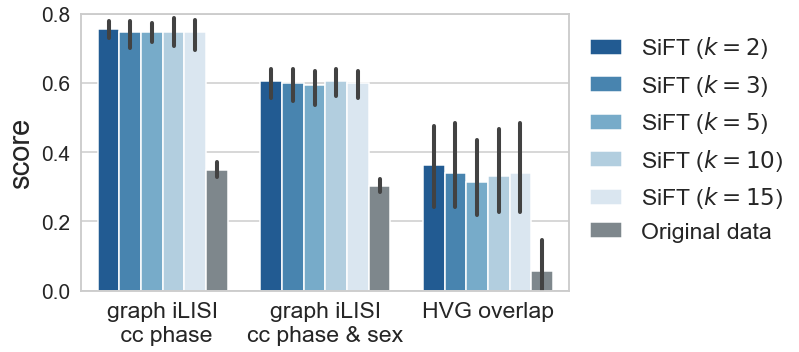

In [45]:
size = 4
fig, axs = plt.subplots(1,1, figsize=(size*2.8, size+1))

bar = sns.barplot(x="metric", 
                  y="value",
                  data=df_scores_lim, 
                  hue="method", 
                  ax=axs, 
                  palette=colors_sift,
                  # ci=None
                 )
        
leg = axs.legend(ncol=1, 
                    loc="upper left", 
                    bbox_to_anchor=(1.0, 1.0),
                    frameon=False, fontsize=fontsize-2)
plt.title("")
plt.xticks(rotation=0,  fontsize=fontsize-2)
plt.ylim(0, 0.8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8] ,fontsize=fontsize-4)
plt.xlabel("", fontsize=fontsize-4)
plt.ylabel("score",  fontsize=fontsize+4)
plt.tight_layout()
fig.savefig(FIG_DIR + f"score_iLISI_hvg_batch_sift_knn.png", bbox_inches="tight", dpi=DPI)
plt.show()